# Multi-Layer Image Generation Pipeline
This notebook demonstrates the process of setting up and running a multi-layer image generation pipeline using custom models and configurations.

## Import Necessary Libraries
Import libraries such as os, sys, math, random, argparse, numpy, PIL, tqdm, torch, and custom models and pipelines.

In [1]:
import os
import sys
import math
import random
import argparse
import numpy as np
from PIL import Image
from tqdm import tqdm
from mmengine.config import Config

import torch
import torch.utils.checkpoint
from torchvision.utils import save_image

from diffusers import FluxTransformer2DModel
from diffusers.utils import check_min_version
from diffusers.configuration_utils import FrozenDict
from diffusers.loaders.peft import _SET_ADAPTER_SCALE_FN_MAPPING

from multi_layer_gen.custom_model_mmdit import CustomFluxTransformer2DModel
from multi_layer_gen.custom_model_transp_vae import AutoencoderKLTransformerTraining as CustomVAE
from multi_layer_gen.custom_pipeline import CustomFluxPipelineCfg

# Check if the minimum version of the diffusers library is installed
check_min_version("0.31.0.dev0")

## Define Helper Functions
Define the `seed_everything` function to set random seeds and the `adjust_coordinate` function to adjust coordinates.

In [2]:
# Define the seed_everything function to set random seeds
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def adjust_coordinate(value, floor_or_ceil, k=16, min_val=0, max_val=1024):
    # Round the value to the nearest multiple of k
    if floor_or_ceil == "floor":
        rounded_value = math.floor(value / k) * k
    else:
        rounded_value = math.ceil(value / k) * k
    # Clamp the value between min_val and max_val
    return max(min_val, min(rounded_value, max_val))

# Define the parse_config function to parse the configuration file
def parse_config(path=None):
    if path is None:
        parser = argparse.ArgumentParser()
        parser.add_argument('config_dir', type=str)
        args = parser.parse_args()
        path = args.config_dir
    config = Config.fromfile(path)
    
    config.config_dir = path

    if "LOCAL_RANK" in os.environ:
        config.local_rank = int(os.environ["LOCAL_RANK"])
    elif "OMPI_COMM_WORLD_LOCAL_RANK" in os.environ:
        config.local_rank = int(os.environ["OMPI_COMM_WORLD_LOCAL_RANK"])
    else:
        config.local_rank = -1

    return config

## Initialize Pipeline
Define the `initialize_pipeline` function to initialize the custom model pipeline. Define the required argments and initialize all needed modules.

In [13]:
def initialize_pipeline(config, args):
    # Load the original Transformer model from the pretrained model
    transformer_orig = FluxTransformer2DModel.from_pretrained(
        config.transformer_varient if hasattr(config, "transformer_varient") else config.pretrained_model_name_or_path, 
        subfolder="" if hasattr(config, "transformer_varient") else "transformer", 
        revision=config.revision, 
        variant=config.variant,
        torch_dtype=torch.bfloat16,
        cache_dir=config.get("cache_dir", None),
    )
    
    # Configure the custom Transformer model
    mmdit_config = dict(transformer_orig.config)
    mmdit_config["_class_name"] = "CustomSD3Transformer2DModel"
    mmdit_config["max_layer_num"] = config.max_layer_num
    mmdit_config = FrozenDict(mmdit_config)
    transformer = CustomFluxTransformer2DModel.from_config(mmdit_config).to(dtype=torch.bfloat16)
    missing_keys, unexpected_keys = transformer.load_state_dict(transformer_orig.state_dict(), strict=False)

    # Fuse initial LoRA weights
    if args.pre_fuse_lora_dir is not None:
        lora_state_dict = CustomFluxPipelineCfg.lora_state_dict(args.pre_fuse_lora_dir)
        CustomFluxPipelineCfg.load_lora_into_transformer(lora_state_dict, None, transformer)
        transformer.fuse_lora(safe_fusing=True)
        transformer.unload_lora() # Unload LoRA parameters

    # Load layer_pe weights
    layer_pe_path = os.path.join(args.ckpt_dir, "layer_pe.pth")
    layer_pe = torch.load(layer_pe_path)
    missing_keys, unexpected_keys = transformer.load_state_dict(layer_pe, strict=False)

    # Initialize the custom pipeline
    pipeline_type = CustomFluxPipelineCfg
    pipeline = pipeline_type.from_pretrained(
        config.pretrained_model_name_or_path,
        transformer=transformer,
        revision=config.revision,
        variant=config.variant,
        torch_dtype=torch.bfloat16,
        cache_dir=config.get("cache_dir", None),
    ).to(torch.device("cuda", index=args.gpu_id))
    pipeline.enable_model_cpu_offload(gpu_id=args.gpu_id) # Save GPU memory

    # Load LoRA weights
    pipeline.load_lora_weights(args.ckpt_dir, adapter_name="layer")

    # Load additional LoRA weights
    if args.extra_lora_dir is not None:
        _SET_ADAPTER_SCALE_FN_MAPPING["CustomFluxTransformer2DModel"] = _SET_ADAPTER_SCALE_FN_MAPPING["FluxTransformer2DModel"]
        pipeline.load_lora_weights(args.extra_lora_dir, adapter_name="extra")
        pipeline.set_adapters(["layer", "extra"], adapter_weights=[1.0, 0.5])

    return pipeline

args = dict(
    cfg_path="multi_layer_gen/configs/multi_layer_resolution512_test.py",
    ckpt_dir="multi_layer_gen/checkpoints/anonymous_region_transformer_ckpt",
    transp_vae_ckpt="multi_layer_gen/checkpoints/transparent_decoder_ckpt.pt",
    pre_fuse_lora_dir="multi_layer_gen/checkpoints/pre_fuse_lora",
    extra_lora_dir=None, # "multi_layer_gen/checkpoints/extra_lora",
    cfg=4.0,
    steps=28,
    seed=43,
    gpu_id=0,
)
args = argparse.Namespace(**args)

# Set random seed
if args.seed is not None:
    seed_everything(args.seed)

# Parse configuration file
cfg_path = args.cfg_path
config = parse_config(cfg_path)

# Initialize pipeline
pipeline = initialize_pipeline(config, args)

# Load multi-layer transparent VAE decoder
transp_vae = CustomVAE()
transp_vae_path = args.transp_vae_ckpt
missing, unexpected = transp_vae.load_state_dict(torch.load(transp_vae_path)['model'], strict=False)
transp_vae.eval()

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ViT Encoder Missing keys: []
ViT Encoder Unexpected keys: ['pos_embedding']


AutoencoderKLTransformerTraining(
  (decoder): ViTEncoder(
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    

## Test Function
Define the `test` function to perform testing and test on given samples.

In [7]:
import math
import matplotlib.pyplot as plt

def test(args, test_sample):

    generator = torch.Generator(device=torch.device("cuda", index=args.gpu_id)).manual_seed(args.seed) if args.seed else None

    this_index = test_sample["index"]
    validation_prompt = test_sample["wholecaption"]
    validation_box_raw = test_sample["layout"]
    validation_box = [
        (
            adjust_coordinate(rect[0], floor_or_ceil="floor"), 
            adjust_coordinate(rect[1], floor_or_ceil="floor"), 
            adjust_coordinate(rect[2], floor_or_ceil="ceil"), 
            adjust_coordinate(rect[3], floor_or_ceil="ceil"), 
        )
        for rect in validation_box_raw
    ]
    if len(validation_box) > 52:
        validation_box = validation_box[:52]
    
    output, rgba_output, _, _ = pipeline(
        prompt=validation_prompt,
        validation_box=validation_box,
        generator=generator,
        height=config.resolution,
        width=config.resolution,
        num_layers=len(validation_box),
        guidance_scale=args.cfg,
        num_inference_steps=args.steps,
        transparent_decoder=transp_vae,
    )
    images = output.images   # list of PIL, len=layers
    rgba_images = [Image.fromarray(arr, 'RGBA') for arr in rgba_output]

    merged_pil = images[1].convert('RGBA')
    for frame_idx, frame_pil in enumerate(rgba_images):
        if frame_idx > 1:
            merged_pil = Image.alpha_composite(merged_pil, frame_pil)

    # Create a single figure to display all images
    num_layers = len(rgba_images)
    total_images = num_layers  # merged image + layers
    cols = 5  # Adjust the number of columns as needed
    rows = math.ceil(total_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()

    # Display merged image first
    axes[0].imshow(merged_pil.convert('RGBA'))
    axes[0].set_title("merged_rgba.png")
    axes[0].axis('off')

    # Display each layer image
    for i, frame_pil in enumerate(rgba_images[1:]):
        axes[i + 1].imshow(frame_pil)
        axes[i + 1].set_title(f"layer_{i}_rgba.png")
        axes[i + 1].axis('off')

    # Hide any unused subplots
    for j in range(total_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

  0%|          | 0/28 [00:00<?, ?it/s]

/opt/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


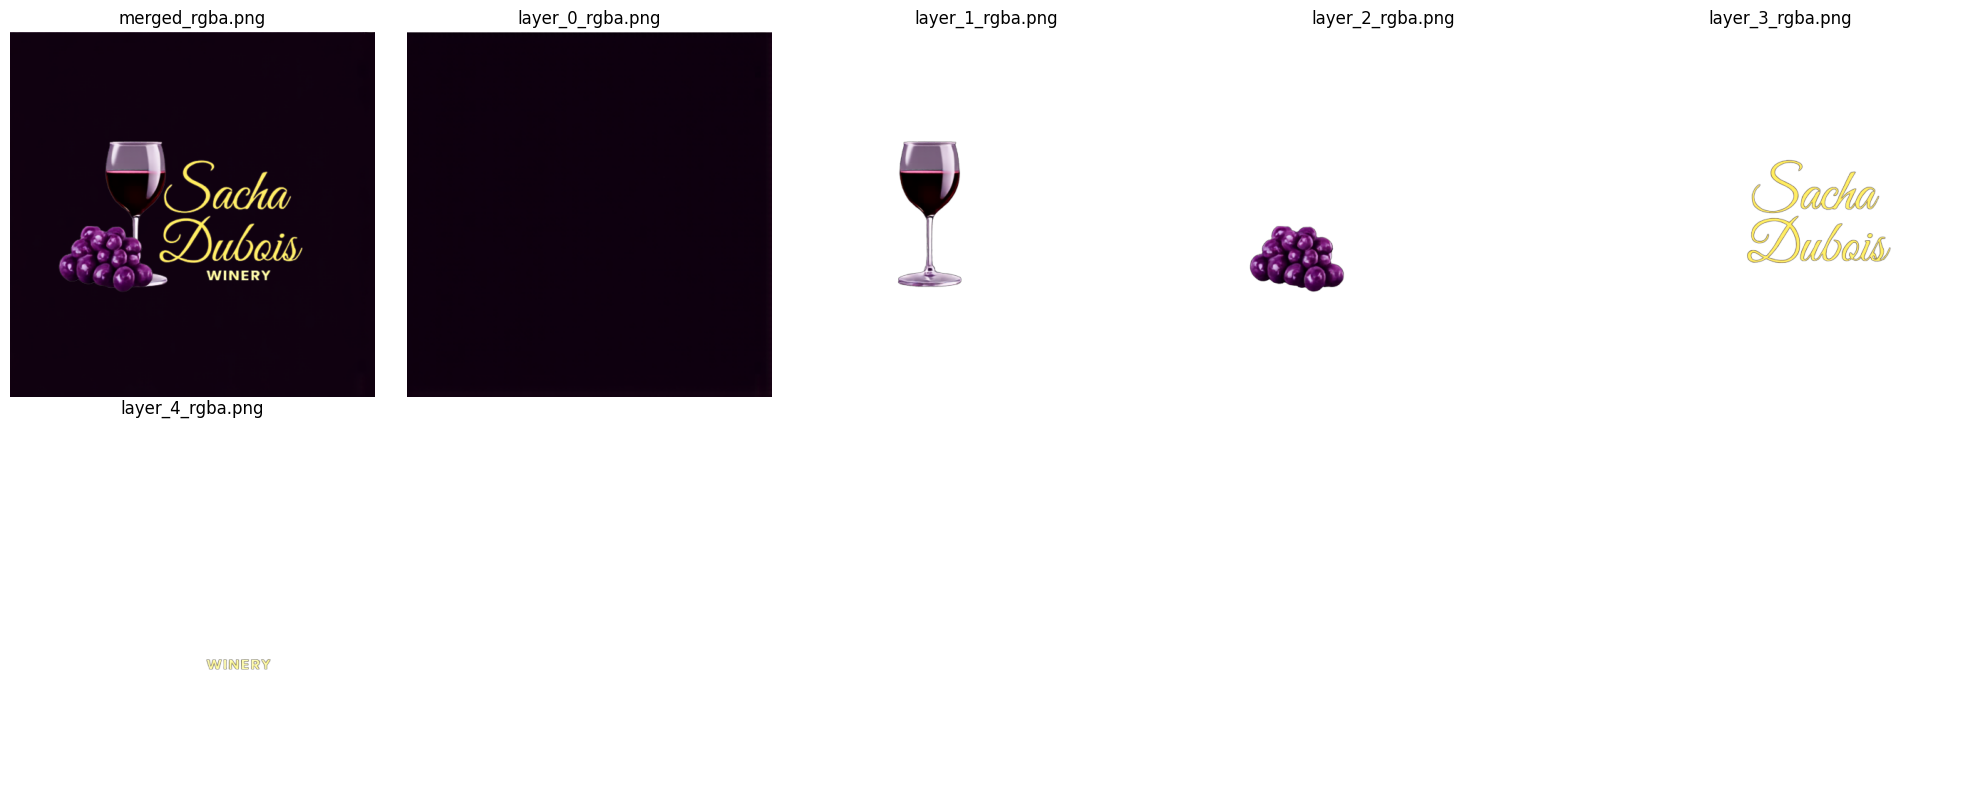

In [14]:
args.seed = 42
sample = {
            "index": "reso512_1",
            "wholecaption": 'Elegant logo for "Sacha Dubois Winery": cursive gold text, larger "Sacha" over "Dubois," small "winery" below. Left: wine glass with purple wine. Right: cluster of purple grapes.',
            "layout": [(0, 0, 512, 512), (0, 0, 512, 512), (136, 144, 224, 360), (72, 272, 200, 368), (216, 176, 408, 328), (272, 328, 368, 360)],
        }

test(args, sample)

Token indices sequence length is longer than the specified maximum sequence length for this model (259 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['" baby shower " are prominently displayed in a larger, more decorative font, suggesting the theme of the event. the background of the invitation is a soft, light pink color, which adds to the gentle and welcoming atmosphere of the design. at the bottom of the image, there is additional text providing specific details about the event. it reads " 2 7 january, 2 0 2 2 - 8 : 0 0 pm " followed by " fauget industries cafe," indicating the date, time, and location of the baby shower. the overall style of the image is warm, inviting, and child - friendly, with a clear focus on the theme of a baby shower celebration. the use of a teddy bear as the central image reinforces the baby - related theme. the design is si

  0%|          | 0/28 [00:00<?, ?it/s]

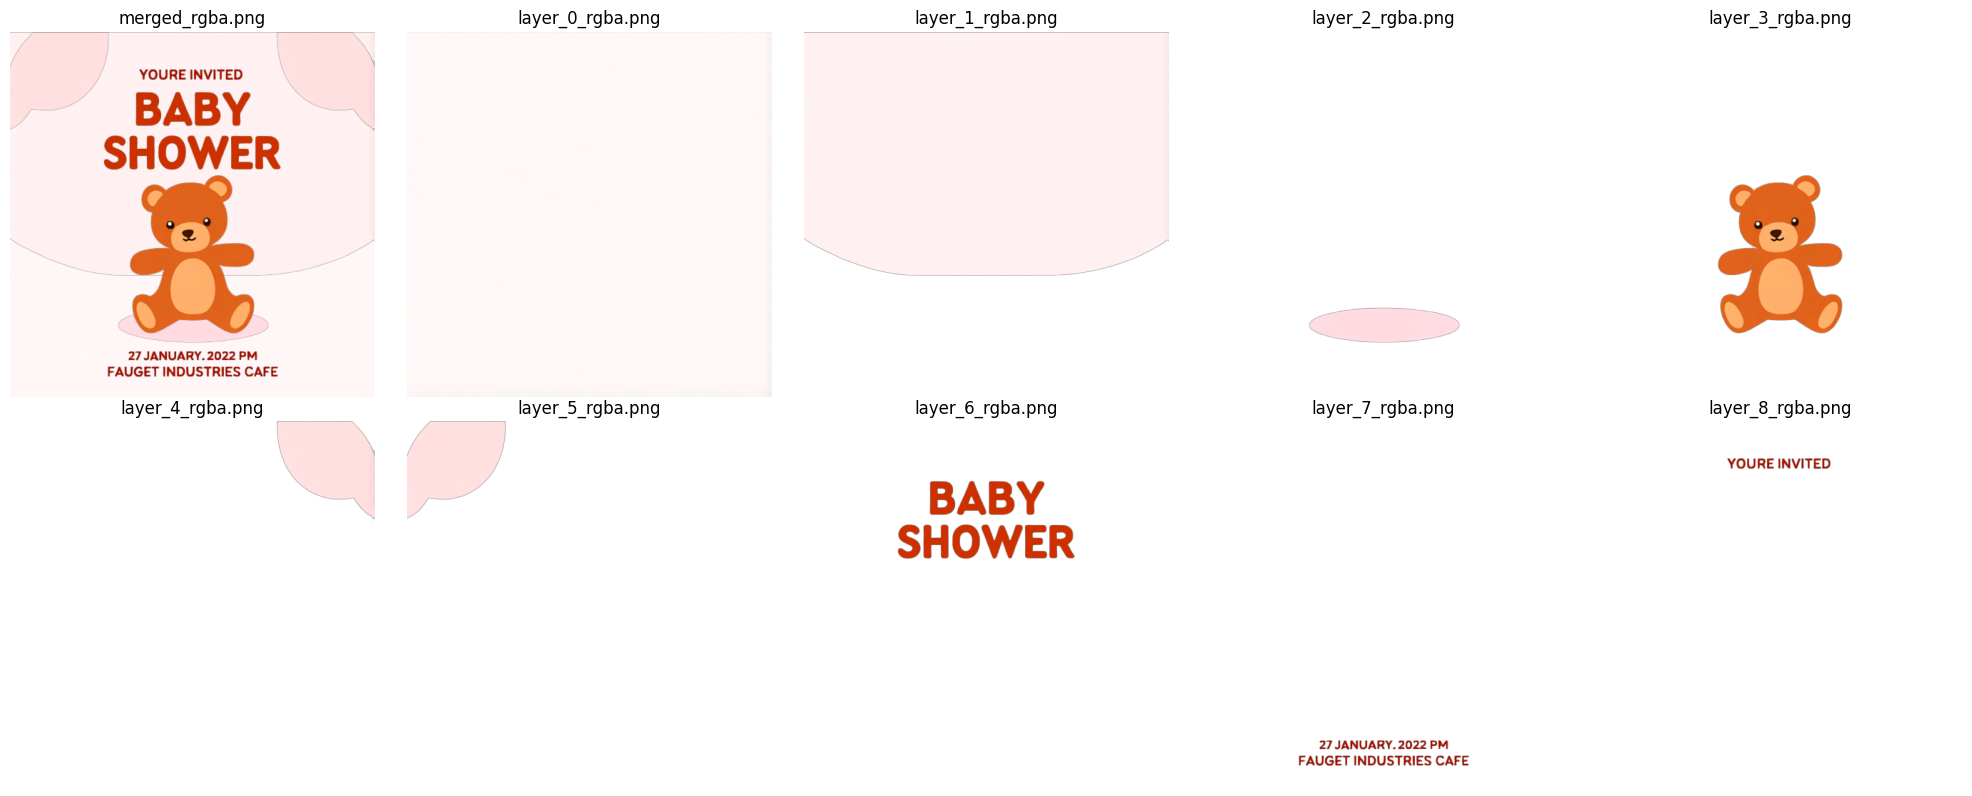

In [15]:
args.seed = 42
sample = {
            "index": "reso512_2",
            "wholecaption": 'The image is a graphic design of a baby shower invitation. The central focus is a cute, cartoon-style teddy bear with a friendly expression, sitting upright. The bear is colored in a soft, light brown hue. Above the bear, there is a bold text that reads "YOU\'RE INVITED" in a playful, sans-serif font. Below this, the words "BABY SHOWER" are prominently displayed in a larger, more decorative font, suggesting the theme of the event.\n\nThe background of the invitation is a soft, light pink color, which adds to the gentle and welcoming atmosphere of the design. At the bottom of the image, there is additional text providing specific details about the event. It reads "27 January, 2022 - 8:00 PM" followed by "FAUGET INDUSTRIES CAFE," indicating the date, time, and location of the baby shower.\n\nThe overall style of the image is warm, inviting, and child-friendly, with a clear focus on the theme of a baby shower celebration. The use of a teddy bear as the central image reinforces the baby-related theme. The design is simple yet effective, with a clear hierarchy of information that guides the viewer\'s attention from the top to the bottom of the invitation.',
            "layout": [(0, 0, 512, 512), (0, 0, 512, 512), (0, 0, 512, 352), (144, 384, 368, 448), (160, 192, 352, 432), (368, 0, 512, 144), (0, 0, 144, 144), (128, 80, 384, 208), (128, 448, 384, 496), (176, 48, 336, 80)],
        }

test(args, sample)

  0%|          | 0/28 [00:00<?, ?it/s]

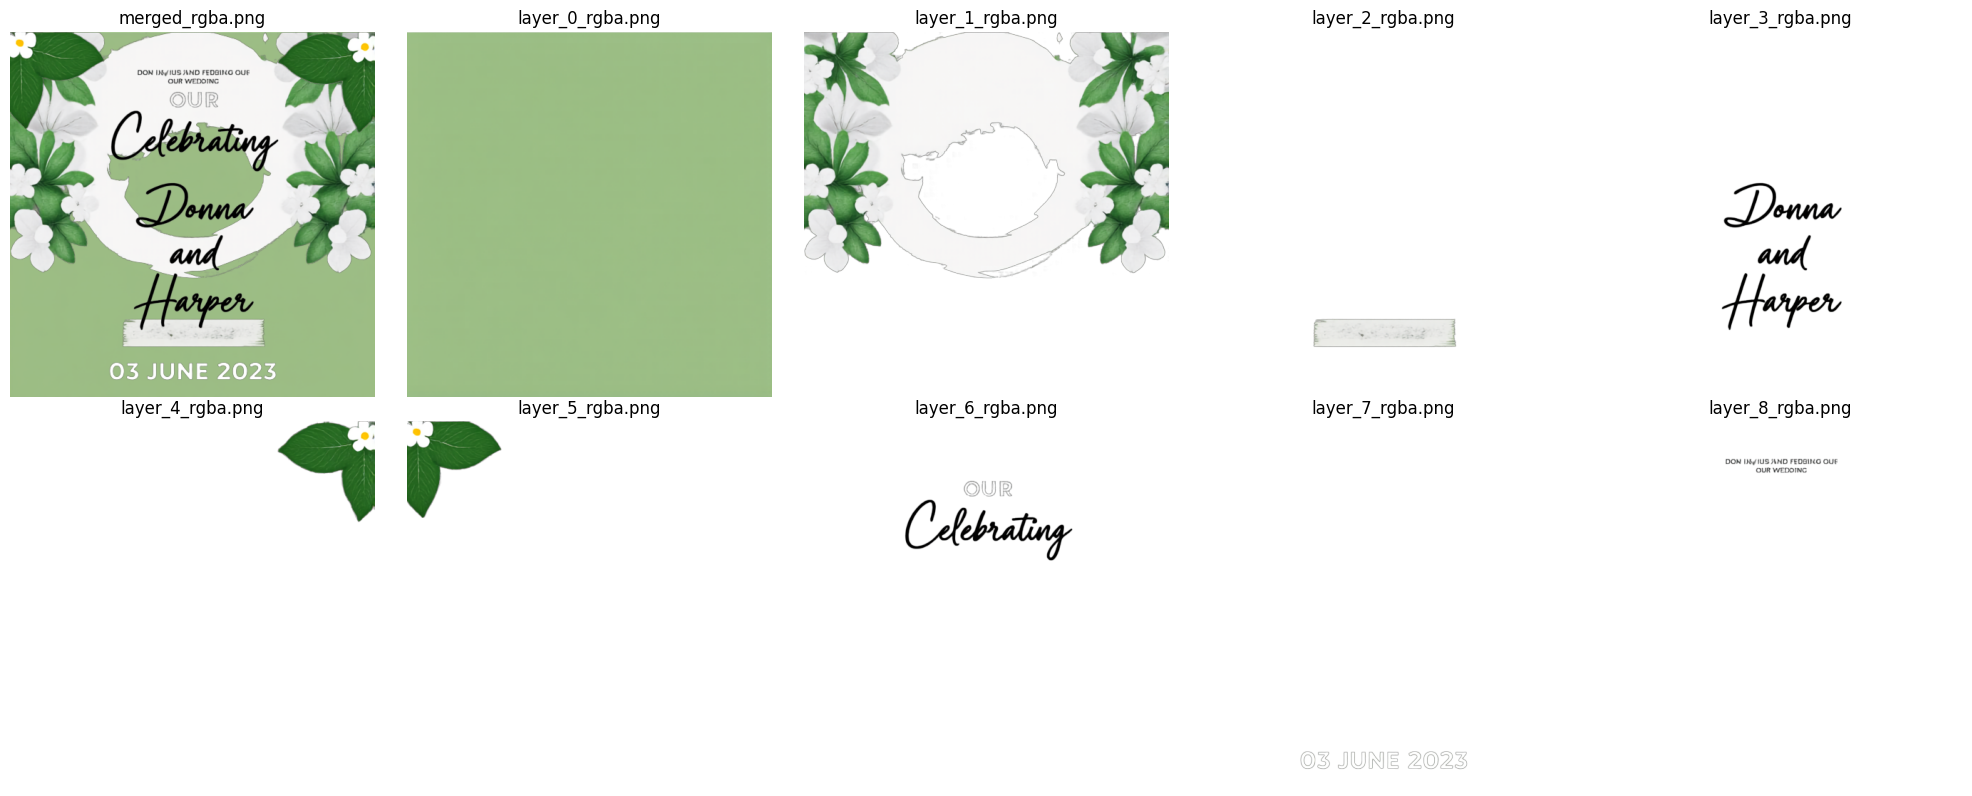

In [16]:
args.seed = 41
sample = {
            "index": "reso512_3",
            "wholecaption": 'Floral wedding invitation: green leaves, white flowers; circular border. Center: "JOIN US CELEBRATING OUR WEDDING" (cursive), "DONNA AND HARPER" (bold), "03 JUNE 2023" (small bold). White, green color scheme, elegant, natural.',
            "layout": [(0, 0, 512, 512), (0, 0, 512, 512), (0, 0, 512, 352), (144, 384, 368, 448), (160, 192, 352, 432), (368, 0, 512, 144), (0, 0, 144, 144), (128, 80, 384, 208), (128, 448, 384, 496), (176, 48, 336, 80)],
        }

test(args, sample)

## Cleaning
Clean the pipeline and all caches.

In [17]:
del pipeline
if torch.cuda.is_available():
    torch.cuda.empty_cache()